**本文已加入 [**🚀 Python AI 计划**](https://github.com/kzbkzb/Python-AI)，从一个Python小白到一个AI大神，你所需要的所有知识都在 [这里](https://github.com/kzbkzb/Python-AI) 了。**
***

- **作者**：[K同学啊](https://www.zhihu.com/people/ni-huan-hao-ma-70-3/posts)
- **数据**：公众号内回复 `DL+35`可以获取数据
- **代码**：全部代码已放入文中，也可以去我的 [GitHub](https://github.com/kzbkzb/Python-AI) 上下载

大家好，我是『K同学啊』！

今天我将带大家探索一下深度学习在医学领域的应用--**脑肿瘤识别**，脑肿瘤也称为颅内肿瘤，是颅内占位性病变的主要疾病，在儿童易患的恶性病变中仅次于白血病，位于第二位。有数据表明，我国每年新增儿童脑瘤患者7000～8000名，其中70%～80%的患儿肿瘤呈恶性。由于脑肿瘤患者年龄越小，发病速度越快，肿瘤恶性程度越高，所以早期发现。治疗成为降低疾病危害的重要方式之一。

这次我们**一共用到了253张脑部扫描图片**数据，其中患有脑肿瘤的患者脑部扫描图片155张，正常人的脑部扫描图片98张。使用的算法为**MobileNetV2**，最后的识别准确率是**90.0%**，AUC值为**0.869**。

**本次的重点：** 相对于《深度学习100例》以往的案例，本次我们将加入**AUC评价指标**来评估脑肿瘤识别的识别效果，AUC（Area under the Curve of ROC）是ROC曲线下方的面积，是判断二分类预测模型优劣的标准。

**我的环境：**

- 语言环境：Python3.8
- 编译器：Jupyter lab
- 深度学习环境：TensorFlow2.4.1

我们的代码流程图如下所示：
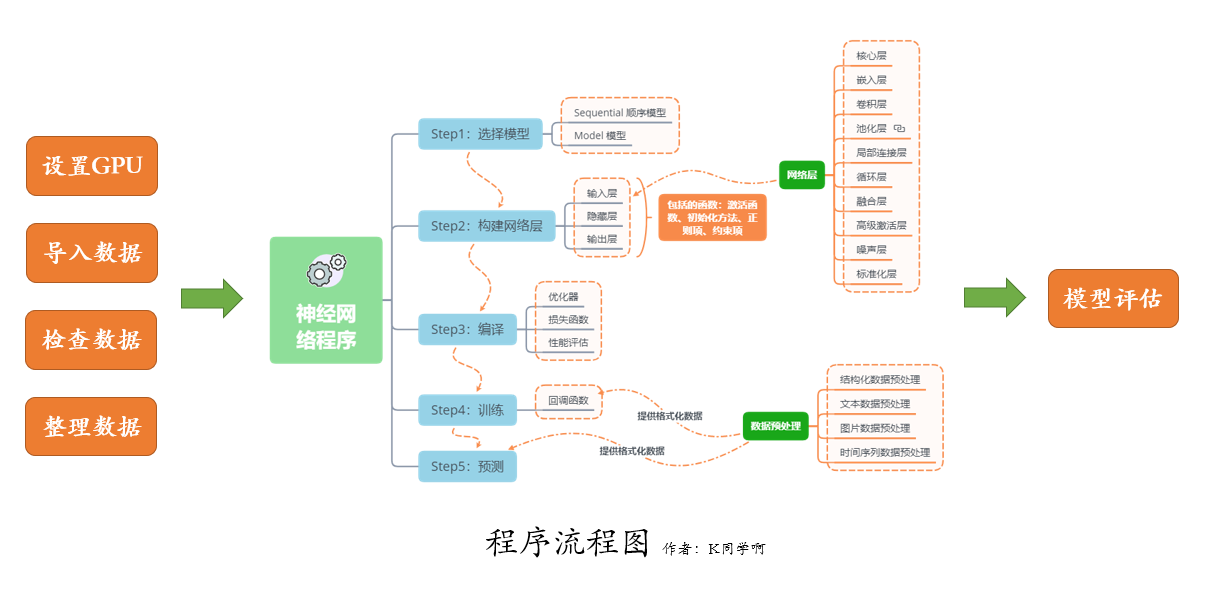

# 一、设置GPU

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")
    
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")             #忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 二、导入数据

## 1. 导入数据

In [2]:
import pathlib

data_dir = "./35-day-brain_tumor_dataset"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("图片总数为：",image_count)

图片总数为： 253


In [3]:
batch_size = 16
img_height = 224
img_width  = 224

In [4]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [5]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## 2. 检查数据

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


## 3. 配置数据集

- **shuffle() ：** 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch() ：** 预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache() ：** 将数据集缓存到内存当中，加速运行

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)           # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)         # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

## 4. 数据可视化

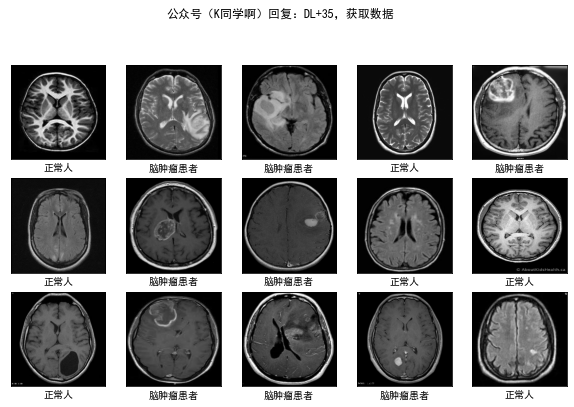

In [9]:
plt.figure(figsize=(10, 8))  # 图形的宽为10高为5
plt.suptitle("公众号（K同学啊）回复：DL+35，获取数据")

class_names = ["脑肿瘤患者","正常人"]

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # 显示图片
        plt.imshow(images[i])
        # 显示标签
        plt.xlabel(class_names[labels[i]-1])

plt.show()

# 三、构建模型

In [10]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

# 加载预训练模型
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                            include_top=False,
                                                            input_shape=(img_width,img_height,3),
                                                            pooling='max')

for layer in base_model.layers:
    layer.trainable = True
    
X = base_model.output
"""
注意到原模型（MobileNetV2）会发生过拟合现象，这里加上一个Dropout层
加上后，过拟合现象得到了明显的改善。
大家可以试着通过调整代码，观察一下注释Dropout层与不注释之间的差别
"""
X = Dropout(0.4)(X)

output = Dense(len(class_names), activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)

# model.summary()

# 四、编译

In [11]:
model.compile(optimizer="adam",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 五、训练模型

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 50
PATIENCE  = 10
VERBOSE   = 1

# 设置动态学习率
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

# 设置早停
earlystopper = EarlyStopping(monitor='val_acc', patience=PATIENCE, verbose=VERBOSE)

# 
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE
                                save_best_only=True,
                                save_weights_only=True)

In [13]:
train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
13/13 [==============================] - 7s 145ms/step - loss: 3.1000 - accuracy: 0.6700 - val_loss: 1.7745 - val_accuracy: 0.6400

Epoch 00001: val_accuracy improved from -inf to 0.64000, saving model to best_model.h5
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 0.9702 - accuracy: 0.8571 - val_loss: 1.4267 - val_accuracy: 0.7600

Epoch 00002: val_accuracy improved from 0.64000 to 0.76000, saving model to best_model.h5
Epoch 3/50
13/13 [==============================] - 1s 58ms/step - loss: 0.6924 - accuracy: 0.9064 - val_loss: 3.4140 - val_accuracy: 0.7400

Epoch 00003: val_accuracy did not improve from 0.76000
Epoch 4/50
13/13 [==============================] - 1s 59ms/step - loss: 0.2761 - accuracy: 0.9507 - val_loss: 2.3684 - val_accuracy: 0.7600

Epoch 00004: val_accuracy did not improve from 0.76000
Epoch 5/50
13/13 [==============================] - 1s 58ms/step - loss: 0.1605 - accuracy: 0.9803 - val_loss: 1.3602 - val_accuracy: 0.8800

Ep

# 六、模型评估

## 1. 混淆矩阵

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [15]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

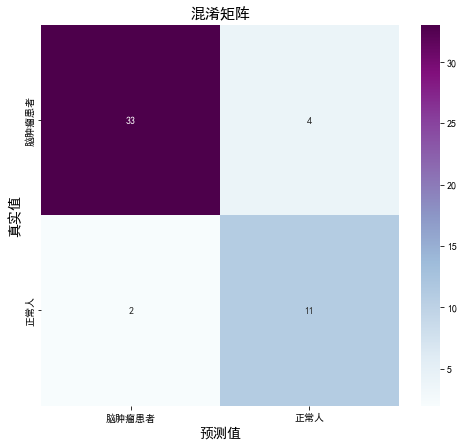

In [16]:
plot_cm(val_label, val_pre)

## 2. 各项指标评估

In [17]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names)) 
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
    
test_accuracy_report(model)

              precision    recall  f1-score   support

       脑肿瘤患者       0.94      0.89      0.92        37
         正常人       0.73      0.85      0.79        13

    accuracy                           0.88        50
   macro avg       0.84      0.87      0.85        50
weighted avg       0.89      0.88      0.88        50

Loss function: 2.668877601623535, accuracy: 0.8799999952316284


## 3. AUC 评价

**一句话介绍：AUC（Area under the Curve of ROC）是ROC曲线下方的面积，是判断二分类预测模型优劣的标准。**

- **AUC = 1**：是完美分类器，绝大多数预测的场合，不存在完美分类器。
- **0.5 < AUC < 1**：优于随机猜测。
- **AUC = 0.5**：跟随机猜测一样（例：丢硬币），模型没有预测价值。
- **AUC < 0.5**：比随机猜测还差。

**ROC曲线的横坐标是伪阳性率**（也叫假正类率，False Positive Rate），**纵坐标是真阳性率**（真正类率，True Positive Rate），相应的还有真阴性率（真负类率，True Negative Rate）和伪阴性率（假负类率，False Negative Rate）。这四类的计算方法如下：

- **伪阳性率（FPR）**：在所有实际为阴性的样本中，被错误地判断为阳性的比率。
- **真阳性率（TPR）**：在所有实际为阳性的样本中，被正确地判断为阳性的比率。
- **伪阴性率（FNR）**：在所有实际为阳性的样本中，被错误的预测为阴性的比率。
- **真阴性率（TNR）**：在所有实际为阴性的样本中，被正确的预测为阴性的比率。

In [18]:
val_pre   = []
val_label = []
for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0)
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(np.argmax(prediction))
        val_label.append(label)
        
train_pre   = []
train_label = []
for images, labels in train_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0)
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        train_pre.append(np.argmax(prediction))
        train_label.append(label)

`sklearn.metrics.roc_curve()`：用于绘制ROC曲线

**主要参数：**
- `y_true`：真实的样本标签，默认为{0，1}或者{-1，1}。如果要设置为其它值，则 pos_label 参数要设置为特定值。例如要令样本标签为{1，2}，其中2表示正样本，则pos_label=2。
- `y_score`：对每个样本的预测结果。
- `pos_label`：正样本的标签。

**返回值：**
- `fpr`：False positive rate。
- `tpr`：True positive rate。
- `thresholds`

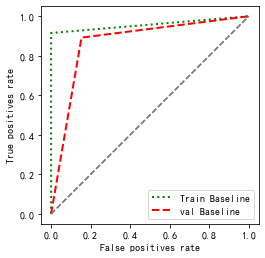

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_roc("Train Baseline", train_label, train_pre, color="green", linestyle=':')
plot_roc("val Baseline", val_label, val_pre, color="red", linestyle='--')

plt.legend(loc='lower right')

In [20]:
auc_score = metrics.roc_auc_score(val_label, val_pre)
print("AUC值为：",auc_score)

AUC值为： 0.869022869022869


***

🥇 需要 **项目定制**、**毕设辅导** 的同学可以加我V.信：mtyjkh_